# Example 5.1 Modeling CSV data with Multilayer Perceptron Networks
The first example from the Deep Learning book is modeling CSV data with a multilayer perceptron network (Patterson and Gibson. 175). This is entended to be a gentile introduction to the DL4J API using a simple model. My plan was to implement this exact model in TensorFlow using modern toolsets like Pandas, for loading data and Keras for creating, training and testing the model. I thought this would be the simpilest model to translate into TensorFlow and Keras, but I was wrong.

The largest stumbling block in this transformation was the use of the Negative Log-Likelihood as the loss function. The log-likelihood is a function that is used in traditional pattern recognition to estimate parmaeters. 

The likelihood is the product of all of the data given the model parameters; e.g., 

$$L = \prod_{k=1}^{N} p(x_k | \Theta) $$

Applying the negative log to the likehood, we get

$$NLL = \sum_{k=1}^{N} -\ln p(x_k | \Theta) $$

where, $$p(x_k | \Theta)$$ is the Gaussian probability of $$x_k$$ given the model parameters $$\Theta$$

The equation for the Gaussian probability is $$ p(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-1/2 ((x - \mu)^2/\sigma^2)}$$

Applying the natural logarithm into the negative log likehood function, we have

$$ NLL = \sum_{k=1}^{N} \frac{ln(2\pi\sigma^2)}{2} + \frac{(x_k - \mu)^2}{2\sigma^2} $$

If we assume that the observed values are samples from a Gaussian distribution with a predicted mean and variance, we can minimize the loss using the negative log-likehood criterion in place of the mean-squared error, with the following loss function, where $$y_k$$ is the true value and $$x_k$$ is the predicted value



## Configure imports

In [1]:
import tensorflow.python.platform
import tensorflow as tf
import pandas as pd
import numpy as np

import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from matplotlib import pyplot

print("Example 5.1 with TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))



Example 5.1 with TensorFlow version: 2.3.0
Eager execution: True


The data used in this example is artifical, two parameter data of two different labels.

We are going to read a few lines from one of the data files to determine how the data is organized.

In [2]:
path_prefix = os.path.join("data", "example1")
filenameTrain = "saturn_data_train.csv"
filenameTest = "saturn_data_eval.csv"

localFilenameTrain = os.path.join(path_prefix, filenameTrain)
localFilenameTest = os.path.join(path_prefix, filenameTest)

# Data by Dr. Jason Baldridge (http://www.jasonbaldridge.com) to test neural network frameworks.
# Read "https://github.com/jasonbaldridge/try-tf/tree/master/simdata" and copy
# to data/example1
if not os.path.isdir(path_prefix) or not os.path.exists(localFilenameTrain) or not os.path.exists(localFilenameTest):
    # The actual URL for the raw data is:
    URL = "https://raw.githubusercontent.com/jasonbaldridge/try-tf/master/simdata/"
    print("Missing Saturn simulation data!")
    print("Downloading from", URL)
    os.mkdir(path_prefix)
    wget.download(URL + "/" + filenameTrain, localFilenameTrain)
    wget.download(URL + "/" + filenameTest, localFilenameTest)

print("\n\nExample 5.1 with TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("The first five lines from the training data file:")
fd = open(localFilenameTrain)
for i in range(5):
    sys.stdout.write(fd.readline())
fd.close()


1,-7.1239700674365,-5.05175898010314

0,1.80771566423302,0.770505522143023

1,8.43184823707231,-4.2287794074931

0,0.451276074541732,0.669574142606103

0,1.52519959303934,-0.953055551414968



Here, we can see tha the file is arranged into three columns. The first column is the label of the two different groups of data (group 0 and group 1). The second column is are the two features. We will assume that these two features are simply the coordinates of the point that is in the labeled group; i.e., x and y. 


In [3]:
# Extract tf.data.Dataset representations of labels and features in CSV files
# given data in the format of label, feat[0], feat[1]. feat[2], etc..
def get_dataset(file_path, plotDataset=False):
    tf.keras.backend.set_floatx('float64')

    # The raw data from the file is easily loaded as a Pandas DataFrame
    df = pd.read_csv(file_path, header=None)

    # The first column is the column of classification labels. Peel off the column of labels as a 
    # vector of 64 bit floating point values.
    labels = df.pop(0).astype(np.float64)

    dataset_length = len(labels)

    # The remainder of the values are the features
    feat = df.values

    if plotDataset:
        pyplot.figure()
        # There are only two labels in this dataset 0 or 1
        idx = labels > 0.5
        pyplot.scatter(feat[idx, 0], feat[idx, 1], marker='+', c='#ff0000')
        idx = labels <= 0.5
        pyplot.scatter(feat[idx, 0], feat[idx, 1], marker='o', c='#00ff00')
        pyplot.show()

    # Assuming that a value of zero is a label, the number of labels it the maximum integer in the array, plus 1
    NUM_LABELS = np.max(labels) + 1

    # Convert the integer lables into a one hot encoding matrix
    labels_onehot = (np.arange(NUM_LABELS) == labels[:, None]).astype(np.float64)
    
    # A tf.data.Dataset represents a sequence of elements, where each element consists of the data and the data label.
    # See: https://www.tensorflow.org/guide/data
    # As one-hot encoded data...
    dataset = tf.data.Dataset.from_tensor_slices((feat, labels_onehot))

    # The Dataset object is Python iterable.
    return dataset, dataset_length

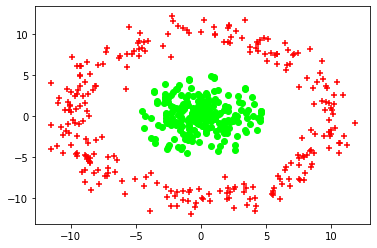



Training data set.
Features: [-7.12397007 -5.05175898], Target: [0. 1.]
Features: [1.80771566 0.77050552], Target: [1. 0.]
Features: [ 8.43184824 -4.22877941], Target: [0. 1.]
Features: [0.45127607 0.66957414], Target: [1. 0.]
Features: [ 1.52519959 -0.95305555], Target: [1. 0.]


Testing data set.
Features: [-2.95364441  0.42407242], Target: [1. 0.]
Features: [9.05324339 3.83322993], Target: [0. 1.]
Features: [-9.41898809 -5.15292208], Target: [0. 1.]
Features: [0.02591421 0.01317695], Target: [1. 0.]
Features: [-5.98582112  9.74872712], Target: [0. 1.]





In [4]:

# Load the training data set
raw_train_data, raw_train_data_length = get_dataset(localFilenameTrain, plotDataset=True)

print("\n\nTraining data set.")
for feat, targ in raw_train_data.take(5):
    print ('Features: {}, Target: {}'.format(feat, targ))

# Load the test/evaluation data set
raw_test_data, raw_test_data_length = get_dataset(localFilenameTest)

print("\n\nTesting data set.")
for feat, targ in raw_test_data.take(5):
    print ('Features: {}, Target: {}'.format(feat, targ))

print("\n\n")

Next, make the regression model to predict the label. For this example, the model has two layers. The input layer is an multilayer perceptron network with an RELU activation function and the output layer is is a softmax activation function with a negative log likelihood loss function. 

The weight initializer from the Deep Learning book is Xavier.

In [5]:

seed = 123
LEARNING_RATE = 0.005
BATCH_SIZE = 50
NUM_EPOCHS = 30 # Number of epochs, full passes of the data
NUM_INPUTS = 2
NUM_OUTPUTS = 2
NUM_HIDDEN_NODES = 20

# Build the model.
model = Sequential([
    tf.keras.layers.Dense(NUM_HIDDEN_NODES, activation='relu'),
    tf.keras.layers.Dense(NUM_OUTPUTS, activation='softmax')
])

# To train using the Dataset, we should shuffle and batch the data
training_batches = raw_train_data.shuffle(raw_train_data_length).batch(BATCH_SIZE)

# Optimizer is Adam, loss function is mean squared error
model.compile(loss = tf.losses.MeanSquaredError(), optimizer = tf.optimizers.Adam(), metrics=['accuracy'])

history = model.fit(training_batches, epochs=NUM_EPOCHS, verbose=1)
model.summary()

Epoch 1/30
10/10 [==============================] - 0s 3ms/step - loss: 0.4360 - accuracy: 0.5080
Epoch 2/30
10/10 [==============================] - 0s 3ms/step - loss: 0.3872 - accuracy: 0.5020
Epoch 3/30
10/10 [==============================] - 0s 3ms/step - loss: 0.3330 - accuracy: 0.5220
Epoch 4/30
10/10 [==============================] - 0s 3ms/step - loss: 0.2693 - accuracy: 0.5520
Epoch 5/30
10/10 [==============================] - 0s 2ms/step - loss: 0.2154 - accuracy: 0.6200
Epoch 6/30
10/10 [==============================] - 0s 3ms/step - loss: 0.1858 - accuracy: 0.6340
Epoch 7/30
10/10 [==============================] - 0s 2ms/step - loss: 0.1713 - accuracy: 0.6300
Epoch 8/30
10/10 [==============================] - 0s 3ms/step - loss: 0.1622 - accuracy: 0.6620
Epoch 9/30
10/10 [==============================] - 0s 3ms/step - loss: 0.1549 - accuracy: 0.6940
Epoch 10/30
10/10 [==============================] - 0s 2ms/step - loss: 0.1479 - accuracy: 0.7400
Epoch 11/30
10/10 [

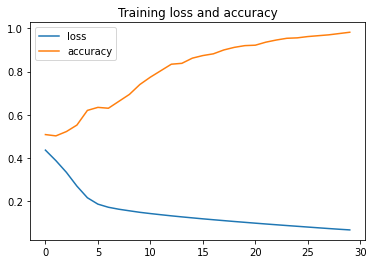

In [6]:
# plot history
pyplot.plot(history.history['loss'], label='loss')
pyplot.plot(history.history['accuracy'], label='accuracy')
pyplot.title('Training loss and accuracy')
pyplot.legend()
pyplot.show()


In [7]:
# Run against the test set. Final evaluation of the model
testing_batches = raw_test_data.shuffle(raw_test_data_length).batch(BATCH_SIZE)
scores = model.evaluate(testing_batches, verbose=0)
print("Test set analysis accuracy: %.2f%%" % (scores[1]*100))

Test set analysis accuracy: 99.00%
